<a href="https://colab.research.google.com/github/shrivi34/Portfolio-Optimisation-Game-Theory/blob/main/PortfolioOptimisationGameTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip  install cvxpy

In [ ]:
!pip install yfinance

In [ ]:
!pip install numpy

In [ ]:
!pip install scipy

In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from typing import Union, Tuple, List, Any

import cvxpy as cp
import numpy as np
import torch


class CPTUtility:
    """
    A utility function that incorporates features from cumulative prospect theory.
    1. Prospect theory utility ('S-shaped'), parametrized by gamma_pos and gamma_neg
    2. Overweighting of extreme outcomes, parametrized by delta_pos and delta_neg
    """

    def __init__(self, gamma_pos: float, gamma_neg: float, delta_pos: float, delta_neg: float):

        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg

        self.delta_pos = delta_pos
        self.delta_neg = delta_neg

        self._validate_arguments()

    @staticmethod
    def _weight(p: np.array, delta: float) -> np.array:
        assert delta >= 0.278, (
            f"[utility] weights are only strictly increasing for delta >= 0.278."
            f"{delta=} was passed."
        )
        return (p**delta) / ((p**delta + np.maximum((1 - p), 0) ** delta) ** (1 / delta))

    def cumulative_weights(self, N: int, delta: float) -> np.array:

        pi = -np.diff(self._weight(np.flip(np.cumsum(np.ones(N) / N)), delta))
        pi = np.append(pi, np.array([self._weight(1 / N, delta)]))

        # make monotone
        assert np.sum(np.diff(np.diff(pi) > 0)) <= 1, "[utility] probabilities should be unimodal."
        idx_min = np.argmin(pi)
        pi[:idx_min] = pi[idx_min]
        return pi

    def evaluate(self, weights: np.array, returns: np.array) -> Tuple[float, float, float]:
        portfolio_returns = returns @ weights
        N = len(portfolio_returns)

        p_weights = self.cumulative_weights(N, delta=self.delta_pos)
        n_weights = self.cumulative_weights(N, delta=self.delta_neg)

        pos_sort = np.sort(np.maximum(portfolio_returns, 0))
        util_p = p_weights @ self.p_util_expression(pos_sort).value

        neg_sort = np.flip(np.sort(np.minimum(portfolio_returns, 0)))
        util_n = n_weights @ self.n_util(neg_sort)

        return util_p - util_n, util_p, util_n

    def _validate_arguments(self) -> None:
        assert self.gamma_neg >= self.gamma_pos > 0, (
            f"[utility] Loss aversion implies gamma_neg >= gamma_pos. "
            f"Here: {self.gamma_neg=}, {self.gamma_pos=}."
        )
        assert self.delta_pos > 0, f"[utility] delta_pos must be positive: {self.delta_pos=}."
        assert self.delta_neg > 0, f"[utility] delta_neg must be positive: {self.delta_neg=}."

    def p_util_expression(self, portfolio_returns: Union[np.array, cp.Expression]) -> cp.Expression:
        return 1 - cp.exp(-self.gamma_pos * portfolio_returns)

    def n_util(self, portfolio_returns: np.array) -> np.array:
        return 1 - np.exp(self.gamma_neg * portfolio_returns)


class ConverterMixin:
    @classmethod
    def convert_to_class(cls: Any, obj: Any) -> None:
        obj.__class__ = cls


class CPTUtilityGA(ConverterMixin, CPTUtility):
    @staticmethod
    def utility_with_gradient(portfolio_returns: torch.Tensor, gamma: torch.Tensor) -> torch.Tensor:
        return 1 - torch.exp(-gamma * portfolio_returns)

    def evaluate_with_gradient(self, weights: torch.Tensor, returns: torch.Tensor) -> torch.Tensor:
        device = weights.device

        R = returns @ weights
        N = R.shape[0]

        pos_sort = torch.sort(torch.maximum(R, torch.tensor(0, device=device)), axis=0)[0]
        p_weights = torch.tensor(self.cumulative_weights(N, delta=self.delta_pos), device=device)

        positive_contribution = p_weights @ self.utility_with_gradient(
            pos_sort, gamma=torch.tensor(self.gamma_pos, device=device)
        )

        neg_sort = torch.sort(-torch.minimum(R, torch.tensor(0, device=device)), axis=0)[0]
        n_weights = torch.tensor(self.cumulative_weights(N, delta=self.delta_neg), device=device)

        negative_contribution = n_weights @ self.utility_with_gradient(
            neg_sort, gamma=torch.tensor(self.gamma_neg, device=device)
        )

        return positive_contribution - negative_contribution


class CPTUtilityMM(ConverterMixin, CPTUtility):
    def get_concave_minorant_expression(
        self,
        returns: np.ndarray,
        new_weights: cp.Variable,
        previous_weights: np.ndarray,
    ) -> Tuple[cp.Expression, cp.Expression, cp.Expression]:
        N = returns.shape[0]
        previous_portfolio_returns = returns @ previous_weights
        new_returns = returns @ new_weights

        p_weights = self.cumulative_weights(N, delta=self.delta_pos)
        n_weights = self.cumulative_weights(N, delta=self.delta_neg)

        lin_neg_util = self.linearize_neg_utility(new_returns, previous_portfolio_returns)
        negative_contributions = cp.dotsort(cp.pos(lin_neg_util), n_weights)

        previous_utility = self.p_util_expression(previous_portfolio_returns).value
        new_utility = self.p_util_expression(new_returns)
        positive_contributions = self.get_linearize_weighted_pos_expression(
            new_utility, previous_utility, p_weights
        )

        ob = positive_contributions - negative_contributions
        return ob, positive_contributions, negative_contributions

    @staticmethod
    def get_linearize_weighted_pos_expression(
        new_utility: cp.Expression, previous_utility: np.array, weights: np.array
    ) -> cp.Expression:
        assert (np.diff(weights) >= -1e-5).all()
        x_0_inds = np.argsort(previous_utility)
        x_0_sorted = previous_utility[x_0_inds]
        x_sorted = new_utility[x_0_inds]
        grad_top_k_pos = weights * (x_0_sorted >= 0)

        weighted_pos_prev = cp.dotsort(cp.pos(previous_utility), weights).value
        return weighted_pos_prev + grad_top_k_pos @ (x_sorted - x_0_sorted)

    def linearize_neg_utility(
        self,
        current_portfolio_returns: cp.Expression,
        previous_portfolio_returns: np.array,
    ) -> cp.Expression:
        """
        Linearizes the negative utility 1-exp(gn * r)
        """
        grad_neg_util = -self.gamma_neg * np.exp(self.gamma_neg * previous_portfolio_returns)
        prev_neg_utils = self.n_util(previous_portfolio_returns)
        return prev_neg_utils + cp.multiply(
            grad_neg_util, (current_portfolio_returns - previous_portfolio_returns)
        )


class CPTUtilityCC(ConverterMixin, CPTUtility):
    def get_approximate_concave_minorant_expression(
        self,
        returns: np.ndarray,
        new_weights: cp.Variable,
        previous_weights: np.ndarray,
        pi: np.ndarray,
    ) -> Tuple[cp.Expression, cp.Expression, cp.Expression, List[cp.Expression]]:
        previous_portfolio_returns = returns @ previous_weights
        new_returns = returns @ new_weights

        lin_neg_utilities = self.linearize_convex_concave_negative(
            new_returns, previous_portfolio_returns
        )
        negative_contributions = pi @ lin_neg_utilities

        pos_utilities, aux_constraints = self.convex_concave_positive(new_returns)
        positive_contributions = pi @ pos_utilities

        ob = positive_contributions + negative_contributions
        return ob, positive_contributions, negative_contributions, aux_constraints

    def linearize_convex_concave_negative(
        self, new_returns: cp.Expression, previous_portfolio_returns: np.array
    ) -> cp.Expression:
        grad_conv = (
            self.gamma_neg * np.exp(self.gamma_neg * previous_portfolio_returns) - self.gamma_neg
        )
        grad_conv[previous_portfolio_returns >= 0] = 0
        prev_conv = (
            -1
            + np.exp(self.gamma_neg * previous_portfolio_returns)
            - self.gamma_neg * previous_portfolio_returns
        )
        prev_conv[previous_portfolio_returns >= 0] = 0
        return prev_conv + cp.multiply(grad_conv, (new_returns - previous_portfolio_returns))

    def convex_concave_positive(
        self, new_returns: cp.Expression
    ) -> Tuple[cp.Variable, List[cp.Expression]]:
        N = new_returns.shape[0]
        r_neg = cp.Variable(N, nonpos=True)
        r_pos = cp.Variable(N, nonneg=True)

        t = cp.Variable(N)
        t1 = cp.Variable(N)
        t2 = cp.Variable(N)

        extended = self.gamma_neg * r_neg
        util = 1 - cp.exp(-self.gamma_pos * r_pos)

        aux_constraints = [
            t <= t1 + t2,
            new_returns == r_neg + r_pos,
            t1 == extended,
            t2 <= util,
        ]
        return t, aux_constraints

import cvxpy as cp
import numpy as np
import torch

from __future__ import annotations

import abc
import copy
import time
from abc import abstractmethod
from typing import Tuple, Optional, Union


class CPTOptimizer(abc.ABC):
    def __init__(self, utility: CPTUtility, max_iter: int = 1000):
        utility = copy.deepcopy(utility)
        self.utility = utility
        self.max_iter = max_iter
        self._weights = None
        self._weights_history = None
        self._wall_time = None

    @abstractmethod
    def optimize(self, r: np.array, verbose: bool = False) -> None:
        pass

    @property
    def weights(self) -> np.array:
        assert self._weights is not None
        return self._weights

    @property
    def weights_history(self) -> np.array:
        assert self._weights_history is not None
        return self._weights_history

    @property
    def wall_time(self) -> np.array:
        assert self._wall_time is not None
        return self._wall_time - np.min(self._wall_time)


class MinorizationMaximizationOptimizer(CPTOptimizer):
    def __init__(self, utility: Union[CPTUtility, CPTUtilityMM], max_iter: int = 1000):
        super().__init__(utility, max_iter)
        if isinstance(self.utility, CPTUtility):
            CPTUtilityMM.convert_to_class(self.utility)

    def optimize(
        self,
        r: np.array,
        verbose: bool = False,
        solver: Optional[str] = cp.SCS,
        initial_weights: Optional[np.array] = None,
        eps: float = 1e-4,
        max_time: float = np.inf,
    ) -> None:

        w_prev = (
            initial_weights if initial_weights is not None else np.ones(r.shape[1]) / r.shape[1]
        )
        weight_history = [w_prev]
        wall_time = [time.time()]
        best_w = w_prev
        best_ob, _, _ = self.utility.evaluate(w_prev, r)

        if verbose:
            print("#" * 50)
            print(" Starting MMOptimizer ".center(50, "#"))
            print("#" * 50 + "\n\n")

        for i in range(self.max_iter):
            w_new, ob_heuristic = self._get_concave_minorant(r, w_prev, solver)
            true_ob, _, _ = self.utility.evaluate(w_new, r)

            if true_ob - best_ob > eps:
                best_ob = true_ob
                best_w = w_new
                w_prev = w_new
                weight_history.append(w_new)
                wall_time.append(time.time())
            else:
                wall_time.append(time.time())
                break

            """
            if verbose:
                print(f" iteration {i} ".center(50, "#"))
                print(
                    f"{ob_heuristic=:.3f}, {true_ob=:.3f}, "
                    f"relative error: {ob_heuristic / true_ob - 1:.3f}"
                )
                """

            if wall_time[-1] - wall_time[0] > max_time:
                wall_time.append(time.time())
                break

        if verbose:
            print(f"final utility: {true_ob:.3f}\n\n")

        self._weights = best_w
        self._weights_history = np.stack(weight_history)
        self._wall_time = np.array(wall_time)

    def _get_concave_minorant(
        self, r: np.array, w_prev: np.array, solver: Optional[str]
    ) -> Tuple[np.array, float]:
        """
        Linearizes convex terms to obtain a concave minorant of the utility
        """

        w = cp.Variable(r.shape[1], nonneg=True)

        ob, _, _ = self.utility.get_concave_minorant_expression(r, w, w_prev)

        constraints = [cp.sum(w) == 1]
        prob = cp.Problem(cp.Maximize(ob), constraints)
        prob.solve(solver=solver)

        return w.value, ob.value


class GradientOptimizer(CPTOptimizer):
    def __init__(
        self,
        utility: Union[CPTUtility, CPTUtilityGA],
        max_iter: int = 100_000,
        gpu: bool = False,
    ):

        super().__init__(utility, max_iter)
        self.device = (
            torch.device("cuda") if (torch.cuda.is_available() and gpu) else torch.device("cpu")
        )
        if isinstance(self.utility, CPTUtility):
            CPTUtilityGA.convert_to_class(self.utility)

        # Help linter
        assert isinstance(self.utility, CPTUtilityGA)
        self.utility = self.utility
        self._all_weights_history = None

    @property
    def all_weights_history(self) -> np.array:
        assert self._all_weights_history is not None
        return self._all_weights_history

    def optimize(
        self,
        returns: torch.Tensor | np.ndarray,
        verbose: bool = False,
        initial_weights: Optional[Union[torch.tensor, np.ndarray]] = None,
        starting_points: Optional[int] = None,
        lr: bool = 1e-1,
        max_time: float = np.inf,
        keep_history: bool = True,
    ) -> None:

        if isinstance(returns, np.ndarray):
            returns = torch.tensor(returns)
        returns = returns.to(self.device)

        if initial_weights is not None:
            assert not starting_points
            if isinstance(initial_weights, np.ndarray):
                if initial_weights.ndim == 1:
                    initial_weights = np.atleast_2d(initial_weights).T
                initial_weights = torch.tensor(initial_weights)
        else:
            initial_weights = torch.ones(returns.shape[1], dtype=torch.float64) / returns.shape[1]
            if starting_points and starting_points > 1:
                dire = torch.distributions.dirichlet.Dirichlet(torch.ones(returns.shape[1]))
                additional_starting_weights = dire.sample([starting_points - 1])
                initial_weights = torch.vstack([initial_weights, additional_starting_weights])
            initial_weights = torch.atleast_2d(initial_weights).T

        unconstrained_w = (
            torch.log(initial_weights).to(self.device).clone().detach().requires_grad_(True)
        )
        optimizer = torch.optim.SGD([unconstrained_w], lr=lr)

        if verbose:
            print("#" * 50)
            print(" Starting GradientOptimizer ".center(50, "#"))
            print("#" * 50 + "\n\n")

        wall_time = [time.time()]
        weight_history = [initial_weights.to(self.device)]
        for i in range(self.max_iter):
            nonneg_weights = torch.exp(unconstrained_w)
            weights = nonneg_weights / nonneg_weights.sum(0, keepdim=True)  # normalize
            util = self.utility.evaluate_with_gradient(weights, returns)
            neg_util = -util
            neg_util.sum().backward()
            optimizer.step()
            optimizer.zero_grad()
            if keep_history:
                weight_history.append(weights)
            wall_time.append(time.time())

            """if verbose and i % (self.max_iter // 10) == 0:
                print(f" iteration {i} ".center(50, "#"))
                print(f"best utility: {util.max():.3f}")"""

            if wall_time[-1] - wall_time[0] > max_time:
                break

        if verbose:
            print(f"final utility: {util.max():.3f}\n\n")

        best_weights = util.argmax()
        self._weights = weights[:, best_weights].cpu().detach().numpy()
        self._wall_time = np.array(wall_time)

        if keep_history:
            self._all_weights_history = torch.stack(weight_history).cpu().detach().numpy()
            self._weights_history = self._all_weights_history[..., best_weights]


class MeanVarianceFrontierOptimizer(CPTOptimizer):
    def optimize(
        self,
        returns: np.array,
        verbose: bool = False,
        solver: Optional[str] = None,
        samples: int = 100,
    ) -> None:

        wall_time = [time.time()]
        mu = np.mean(returns, axis=0)
        Sigma = np.cov(returns, rowvar=False)

        min_vol = np.sqrt(self._get_min_variance(Sigma))
        max_vol = np.sqrt(self._get_max_return_variance(mu))

        var_target = cp.Parameter()

        best_weights = None
        best_cpt_utility = -np.inf

        w = cp.Variable(len(mu), nonneg=True)
        objective = cp.Maximize(w @ mu)
        constraints = [cp.sum(w) == 1, cp.quad_form(w, Sigma) <= var_target]
        problem = cp.Problem(objective, constraints)

        if verbose:
            print("#" * 50)
            print(" Starting MeanVarianceOptimizer ".center(50, "#"))
            print("#" * 50 + "\n\n")

        weight_history = []
        for vol_target_val in np.linspace(min_vol, max_vol, samples):
            var_target.value = vol_target_val**2
            problem.solve()
            cpt_util = self.utility.evaluate(w.value, returns)[0]
            wall_time.append(time.time())
            weight_history.append(w.value)

            """if verbose:
                print(f" volatility target {vol_target_val:.3f} ".center(50, "#"))
                print(f"utility: {cpt_util:.3f}")"""

            if cpt_util > best_cpt_utility:
                best_weights = w.value
                best_cpt_utility = cpt_util

        if verbose:
            print(f"final utility: {best_cpt_utility:.3f}\n\n")

        self._weights = best_weights
        self._weights_history = np.stack(weight_history)
        self._wall_time = np.array(wall_time)

    @staticmethod
    def _get_min_variance(Sigma: np.array) -> np.float:
        w = cp.Variable(Sigma.shape[0], nonneg=True)
        objective = cp.Minimize(cp.quad_form(w, Sigma))
        constraints = [cp.sum(w) == 1]
        problem = cp.Problem(objective, constraints)
        problem.solve()
        return objective.value

    @staticmethod
    def _get_max_return_variance(mu: np.array) -> np.float:
        w = cp.Variable(len(mu), nonneg=True)
        objective = cp.Maximize(w @ mu)
        constraints = [cp.sum(w) == 1]
        problem = cp.Problem(objective, constraints)
        problem.solve()
        return objective.value


class ConvexConcaveOptimizer(CPTOptimizer):
    def __init__(self, utility: Union[CPTUtility, CPTUtilityCC], max_iter: int = 1000):
        super().__init__(utility, max_iter)
        if isinstance(self.utility, CPTUtility):
            CPTUtilityCC.convert_to_class(self.utility)

    def optimize(
        self,
        r: np.array,
        verbose: bool = False,
        solver: Optional[str] = None,
        initial_weights: Optional[np.array] = None,
        eps: float = 1e-4,
        max_time: float = np.inf,
    ) -> None:

        w_prev = (
            initial_weights if initial_weights is not None else np.ones(r.shape[1]) / r.shape[1]
        )

        wall_time = [time.time()]
        weight_history = [w_prev]
        best_w = w_prev
        true_ob, _, _ = self.utility.evaluate(w_prev, r)
        best_ob = true_ob

        if verbose:
            print("#" * 50)
            print(" Starting ConvexConcaveOptimizer ".center(50, "#"))
            print("#" * 50 + "\n\n")

        for i in range(self.max_iter):

            trust_region = 1.0
            smallest_trust = 1e-3
            while trust_region > smallest_trust:

                pi = self.get_pi_from_w_prev(r, w_prev)
                w_new, ob_heuristic = self._get_approximate_concave_minorant(
                    r, w_prev, pi, trust_region, solver
                )
                true_ob, _, _ = self.utility.evaluate(w_new, r)

                if true_ob - best_ob > eps:
                    best_ob = true_ob
                    best_w = w_new
                    w_prev = w_new
                    break
                else:
                    trust_region /= 1.5

            if trust_region > smallest_trust:
                weight_history.append(w_new)
                wall_time.append(time.time())
            else:
                wall_time.append(time.time())
                break
            """
            if verbose:
                print(f" iteration {i} ".center(50, "#"))
                print(
                    f"{ob_heuristic=:.3f}, {true_ob=:.3f}, "
                    f"relative error: {ob_heuristic / true_ob - 1:.3f}"
                )

            if wall_time[-1] - wall_time[0] > max_time:
                wall_time.append(time.time())
                break"""

        if verbose:
            print(f"final utility: {true_ob:.3f}\n\n")

        self._weights = best_w
        self._weights_history = np.stack(weight_history)
        self._wall_time = np.array(wall_time)

    def _get_approximate_concave_minorant(
        self,
        r: np.array,
        w_prev: np.array,
        pi: np.array,
        trust_region: float,
        solver: Optional[str],
    ) -> Tuple[np.array, float]:
        """
        Linearizes convex terms for a pis to obtain an approximate concave minorant of the utility
        """

        w = cp.Variable(r.shape[1], nonneg=True)

        (
            ob,
            _,
            _,
            aux_constraints,
        ) = self.utility.get_approximate_concave_minorant_expression(r, w, w_prev, pi)

        constraints = [
            cp.sum(w) == 1,
            cp.norm_inf(w - w_prev) <= trust_region,
        ] + aux_constraints
        prob = cp.Problem(cp.Maximize(ob), constraints)
        prob.solve(solver=solver)

        return w.value, ob.value

    def get_pi_from_w_prev(self, r: np.array, w_prev: np.array) -> np.array:
        N = r.shape[0]
        previous_portfolio_returns = r @ w_prev

        pos_inds = previous_portfolio_returns >= 0
        neg_inds = ~pos_inds

        pos_returns = previous_portfolio_returns[pos_inds]
        neg_returns = previous_portfolio_returns[neg_inds]

        p_weights = self.utility.cumulative_weights(N, delta=self.utility.delta_pos)[
            -len(pos_returns):
        ]
        n_weights = self.utility.cumulative_weights(N, delta=self.utility.delta_neg)[
            -len(neg_returns):
        ]

        p_weights_sorted = p_weights[pos_returns.argsort().argsort()]
        n_weights_sorted = n_weights[(-neg_returns).argsort().argsort()]

        pi = np.zeros(N)
        pi[pos_inds] = p_weights_sorted
        pi[neg_inds] = n_weights_sorted
        return pi



import numpy as np
from scipy.stats import multivariate_normal as normal
import scipy.optimize as opt
import yfinance as yf
"""
# Generate returns
corr = np.array([
    [1, -.2, -.4],
    [-.2, 1, .5],
    [-.4, .5, 1]
])
sd = np.array([.01, .1, .2])
Sigma = np.diag(sd) @ corr @ np.diag(sd)

np.random.seed(0)
r = normal.rvs([.03, .1, .193], Sigma, size=100)

# Define utility function
"""
tickers = ['AAPL', 'MSFT', 'GOOGL']

# Download historical data for these stocks with monthly intervals
data = yf.download(tickers, start="2018-01-01", end="2023-01-01", interval='1mo')['Adj Close']

# Calculate monthly returns
r = data.pct_change().dropna()

utility = CPTUtility(
    gamma_pos=8.4, gamma_neg=11.4,
    delta_pos=.77, delta_neg=.79
)



initial_weights = np.array([1/3, 1/3, 1/3])
#################################################################
"""
mu = np.mean(r, axis=0)

def mean_variance_utility(w, mu, Sigma, gamma=10):
    expected_return = np.dot(w, mu)
    portfolio_variance = np.dot(w.T, np.dot(Sigma, w))
    return expected_return - 0.5 * gamma * portfolio_variance

def mean_variance_optimization(mu, Sigma, gamma=10):
    # Number of assets
    num_assets = len(mu)

    # Objective function to minimize (we need to negate the utility to use a minimizer)
    def objective(w):
        expected_return = np.dot(w, mu)
        portfolio_variance = np.dot(w.T, np.dot(Sigma, w))
        utility = expected_return - 0.5 * gamma * portfolio_variance
        return -utility  # Minimize the negative to maximize utility

    # Constraints: sum of weights = 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds: weights between 0 and 1 (can adjust if allowing short sales)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Initial guess (equal distribution)
    initial_guess = np.array([1 / num_assets] * num_assets)

    # Optimize
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    # Retrieve the optimal weights and the maximum utility
    if result.success:
        optimal_weights = result.x
        max_utility = -result.fun  # Negate back to get the actual utility
        return optimal_weights, max_utility
    else:
        raise ValueError("Optimization failed: " + result.message)



##################################################################
#mv_utility = mean_variance_utility(initial_weights, mu, Sigma)
#print("Mean-Variance Utility for initial weights:", mv_utility)
###################
"""
# Optimize
mv = MeanVarianceFrontierOptimizer(utility)
mv.optimize(r.values, verbose=True)

mm = MinorizationMaximizationOptimizer(utility)
mm.optimize(r.values, initial_weights=initial_weights, verbose=True)

cc = ConvexConcaveOptimizer(utility)
cc.optimize(r.values, initial_weights=initial_weights, verbose=True)

ga = GradientOptimizer(utility)
ga.optimize(r.values, initial_weights=initial_weights, verbose=True)

[*********************100%%**********************]  3 of 3 completed


##################################################
######### Starting MeanVarianceOptimizer #########
##################################################


final utility: 0.069


##################################################
############## Starting MMOptimizer ##############
##################################################


final utility: 0.069


##################################################
######## Starting ConvexConcaveOptimizer #########
##################################################


final utility: 0.068


##################################################
########### Starting GradientOptimizer ###########
##################################################


final utility: 0.069




In [ ]:
# Assuming mv, mm, cc, ga are the optimizers that have already been run and have attributes weights

print("Optimal Weights from Mean-Variance Frontier Optimizer:", ', '.join(f"{weight:.2f}" for weight in mv.weights))
print("Optimal Weights from Minorization Maximization Optimizer:", ', '.join(f"{weight:.2f}" for weight in mm.weights))
print("Optimal Weights from Convex-Concave Optimizer:", ', '.join(f"{weight:.2f}" for weight in cc.weights))
print("Optimal Weights from Gradient Optimizer:", ', '.join(f"{weight:.2f}" for weight in ga.weights))


Optimal Weights from Mean-Variance Frontier Optimizer: 0.14, 0.00, 0.86
Optimal Weights from Minorization Maximization Optimizer: 0.18, 0.00, 0.82
Optimal Weights from Convex-Concave Optimizer: 0.38, 0.00, 0.62
Optimal Weights from Gradient Optimizer: 0.60, 0.00, 0.40


In [ ]:
import numpy as np

# Assuming 'returns' is a DataFrame with asset returns
# and 'mv.weights', 'mm.weights', 'cc.weights', 'ga.weights' are the weights from each optimizer

# Convert returns to numpy array if it's not already
asset_returns = r.values

# Function to calculate total portfolio return
def calculate_total_return(weights, asset_returns):
    # Calculate portfolio return for each period
    portfolio_returns = np.dot(asset_returns, weights)
    # Sum up all period returns to get the total return
    total_return = np.sum(portfolio_returns)
    return total_return

# Calculate total returns for each optimizer
total_return_mv = calculate_total_return(mv.weights, asset_returns)
total_return_mm = calculate_total_return(mm.weights, asset_returns)
total_return_cc = calculate_total_return(cc.weights, asset_returns)
total_return_ga = calculate_total_return(ga.weights, asset_returns)

# Print results
print(f"Total Return from Mean-Variance Frontier Optimizer: {total_return_mv:.2f}")
print(f"Total Return from Minorization Maximization Optimizer: {total_return_mm:.2f}")
print(f"Total Return from Convex-Concave Optimizer: {total_return_cc:.2f}")
print(f"Total Return from Gradient Optimizer: {total_return_ga:.2f}")

# Determine which optimizer had the highest total return
best_return = max(total_return_mv, total_return_mm, total_return_cc, total_return_ga)
best_optimizer = "Mean-Variance" if best_return == total_return_mv else \
                 "Minorization Maximization" if best_return == total_return_mm else \
                 "Convex-Concave" if best_return == total_return_cc else \
                 "Gradient"
print(f"Best optimizer based on total return: {best_optimizer}")


Total Return from Mean-Variance Frontier Optimizer: 1.15
Total Return from Minorization Maximization Optimizer: 1.17
Total Return from Convex-Concave Optimizer: 1.23
Total Return from Gradient Optimizer: 1.31
Best optimizer based on total return: Gradient


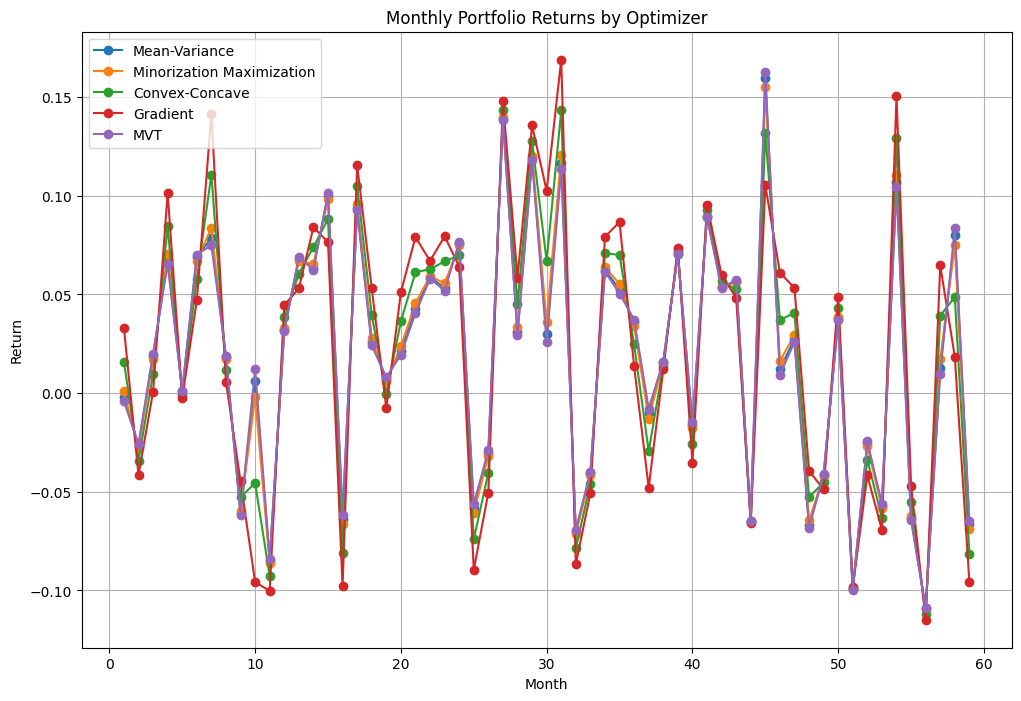

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def calculate_periodic_returns(weights, asset_returns):
    # Calculate portfolio return for each period
    portfolio_returns = np.dot(asset_returns, weights)
    return portfolio_returns


###########
# Calculate expected returns and covariance matrix from historical returns
expected_returns = np.mean(asset_returns, axis=0)
covariance_matrix = np.cov(asset_returns, rowvar=False)

# Risk aversion coefficient (adjust as necessary for your risk preference)
risk_aversion = 0.5

# Function to calculate the negative Sharpe ratio (because we will minimize this function)
def negative_sharpe_ratio(weights):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    # Negative Sharpe ratio (we use negative because we are going to minimize this function)
    return -(portfolio_return - risk_aversion * portfolio_volatility)

# Constraints and bounds for the optimization
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # The weights must sum to 1
bounds = tuple((0, 1) for asset in range(len(expected_returns)))  # Weights can be between 0 and 1 for each asset

# Initial guess (equal distribution)
initial_weights = np.array([1. / len(expected_returns)] * len(expected_returns))

# Optimization function to find the minimum negative Sharpe ratio
opt_result = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal weights
optimal_weights_mvt = opt_result.x
total_return_mvt = calculate_total_return(optimal_weights_mvt, asset_returns)
##########

periodic_returns_mv = calculate_periodic_returns(mv.weights, asset_returns)
periodic_returns_mm = calculate_periodic_returns(mm.weights, asset_returns)
periodic_returns_cc = calculate_periodic_returns(cc.weights, asset_returns)
periodic_returns_ga = calculate_periodic_returns(ga.weights, asset_returns)
periodic_returns_mvt = calculate_periodic_returns(optimal_weights_mvt, asset_returns)

# Plotting the results
months = np.arange(len(periodic_returns_mv)) + 1  # Assuming returns start from month 1

plt.figure(figsize=(12, 8))
plt.plot(months, periodic_returns_mv, label='Mean-Variance', marker='o')
plt.plot(months, periodic_returns_mm, label='Minorization Maximization', marker='o')
plt.plot(months, periodic_returns_cc, label='Convex-Concave', marker='o')
plt.plot(months, periodic_returns_ga, label='Gradient', marker='o')
plt.plot(months, periodic_returns_mvt, label='MVT', marker='o')
plt.title('Monthly Portfolio Returns by Optimizer')
plt.xlabel('Month')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

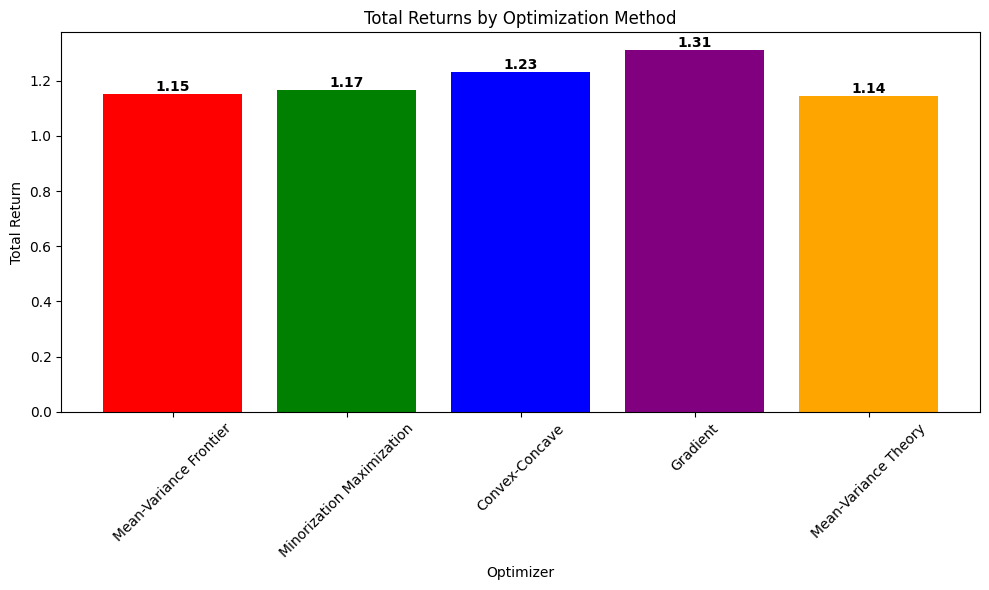

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
optimizers = ['Mean-Variance Frontier', 'Minorization Maximization', 'Convex-Concave', 'Gradient', 'Mean-Variance Theory']
total_returns = [total_return_mv, total_return_mm, total_return_cc, total_return_ga, total_return_mvt]
colors = ['blue', 'green', 'red', 'purple', 'cyan']  # Different colors for each bar

# Creating the bar graph
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(optimizers, total_returns, color=colors)  # Create a bar chart with different colors

# Adding titles and labels
plt.title('Total Returns by Optimization Method')
plt.xlabel('Optimizer')
plt.ylabel('Total Return')
plt.xticks(rotation=45)  # Rotate the labels on the x-axis for better visibility

# Annotating bars with the return values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()


In [ ]:
def calculate_volatility(weights, asset_returns):
    # Calculate portfolio return for each period
    portfolio_returns = np.dot(asset_returns, weights)
    # Calculate the standard deviation of these returns
    volatility = np.std(portfolio_returns)
    return volatility
volatility_mv = calculate_volatility(mv.weights, asset_returns)
volatility_mm = calculate_volatility(mm.weights, asset_returns)
volatility_cc = calculate_volatility(cc.weights, asset_returns)
volatility_ga = calculate_volatility(ga.weights, asset_returns)
volatility_mvt = calculate_volatility(optimal_weights_mvt, asset_returns)

# Print results
print(f"Portfolio Volatility from Mean-Variance Frontier Optimizer: {volatility_mv:.2f}")
print(f"Portfolio Volatility from Minorization Maximization Optimizer: {volatility_mm:.2f}")
print(f"Portfolio Volatility from Convex-Concave Optimizer: {volatility_cc:.2f}")
print(f"Portfolio Volatility from Gradient Optimizer: {volatility_ga:.2f}")
print(f"Portfolio Volatility from MVT Optimizer: {volatility_mvt:.2f}")

# Determine which optimizer had the lowest volatility
lowest_volatility = min(volatility_mv, volatility_mm, volatility_cc, volatility_ga, volatility_mvt)
if lowest_volatility == volatility_mv:
    best_optimizer_for_volatility = "Mean-Variance"
elif lowest_volatility == volatility_mm:
    best_optimizer_for_volatility = "Minorization Maximization"
elif lowest_volatility == volatility_cc:
    best_optimizer_for_volatility = "Convex-Concave"
elif lowest_volatility == volatility_ga:
    best_optimizer_for_volatility = "Gradient"
else:
    best_optimizer_for_volatility = "MVT"

print(f"Best optimizer based on lowest volatility: {best_optimizer_for_volatility}")

Portfolio Volatility from Mean-Variance Frontier Optimizer: 0.06
Portfolio Volatility from Minorization Maximization Optimizer: 0.06
Portfolio Volatility from Convex-Concave Optimizer: 0.07
Portfolio Volatility from Gradient Optimizer: 0.08
Portfolio Volatility from MVT Optimizer: 0.06
Best optimizer based on lowest volatility: Multi-Variable Threshold


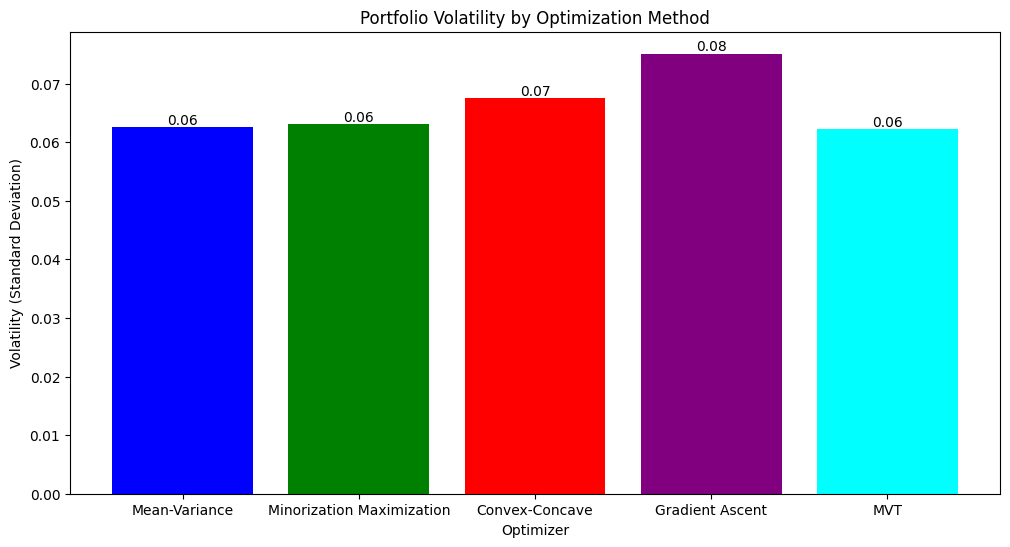

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'returns' is a DataFrame with asset returns
# and 'mv.weights', 'mm.weights', 'cc.weights', 'ga.weights' are the weights from each optimizer

# Convert returns to numpy array if it's not already
asset_returns = r.values

# Function to calculate portfolio volatility
def calculate_volatility(weights, asset_returns):
    # Calculate portfolio return for each period
    portfolio_returns = np.dot(asset_returns, weights)
    # Calculate the standard deviation of these returns
    volatility = np.std(portfolio_returns)
    return volatility

volatility_mv = calculate_volatility(mv.weights, asset_returns)
volatility_mm = calculate_volatility(mm.weights, asset_returns)
volatility_cc = calculate_volatility(cc.weights, asset_returns)
volatility_ga = calculate_volatility(ga.weights, asset_returns)
volatility_mvt = calculate_volatility(optimal_weights_mvt, asset_returns)  # new optimizer

# Data for plotting
optimizers = ['Mean-Variance', 'Minorization Maximization', 'Convex-Concave', 'Gradient Ascent', 'MVT']  # Added new optimizer
volatilities = [volatility_mv, volatility_mm, volatility_cc, volatility_ga, volatility_mvt]
colors = ['blue', 'green', 'red', 'purple', 'cyan']  # Added new color for the new bar

# Creating bar graph
plt.figure(figsize=(12, 6))  # Adjusted for better fit of new data
bars = plt.bar(optimizers, volatilities, color=colors)

# Adding the value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding titles and labels
plt.title('Portfolio Volatility by Optimization Method')
plt.xlabel('Optimizer')
plt.ylabel('Volatility (Standard Deviation)')

# Displaying the plot
plt.show()